In [17]:
!pip freeze > requirements.txt

In [ ]:
!pip install -q mlflow[mlserver]
!pip install -q mlflow[extras]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.4/703.4 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.5/95.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.

In [5]:
# Entrainement du modèle:

import mlflow

import numpy as np
from sklearn import datasets, metrics
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mlflow.set_tracking_uri('http://localhost:5000')

def eval_metrics(pred, actual):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2


# Set the experiment name
mlflow.set_experiment("wine-quality")

# Enable auto-logging to MLflow
mlflow.sklearn.autolog()

# Load wine quality dataset
X, y = datasets.load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Start a run and train a model
with mlflow.start_run(run_name="default-params"):
    lr = ElasticNet()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_test)
    metrics = eval_metrics(y_pred, y_test)


🏃 View run default-params at: http://0.0.0.0:5000/#/experiments/931111745038614296/runs/1912823b35e74e8c88786a09866cd9f0
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/931111745038614296


In [8]:
!curl http://localhost:5000

<!doctype html><html lang="en"><head><meta charset="utf-8"/><meta name="viewport" content="width=device-width,initial-scale=1,shrink-to-fit=no"/><link rel="shortcut icon" href="./static-files/favicon.ico"/><meta name="theme-color" content="#000000"/><link rel="manifest" href="./static-files/manifest.json" crossorigin="use-credentials"/><title>MLflow</title><script defer="defer" src="static-files/static/js/main.e1ed6ef5.js"></script><link href="static-files/static/css/main.702595df.css" rel="stylesheet"></head><body><noscript>You need to enable JavaScript to run this app.</noscript><div id="root" class="mlflow-ui-container"></div><div id="modal" class="mlflow-ui-container"></div></body></html>

Allons dans l'interface de MLflow pour voir les performances de ce modèle:
```
mlflow ui --port 5000
```

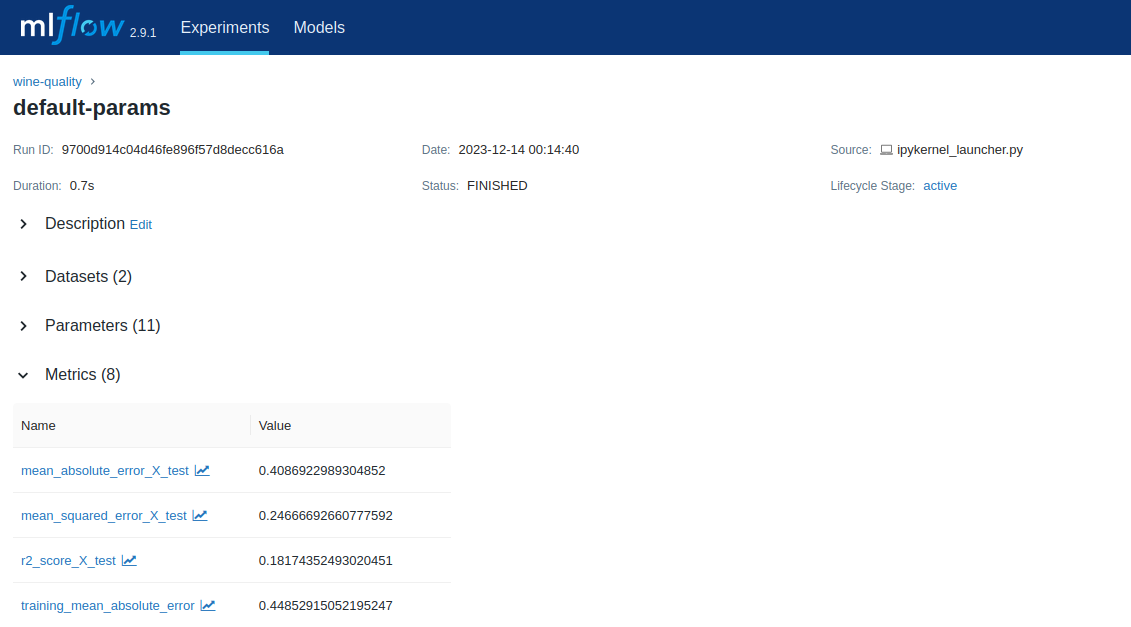

Maintenant, tentons d'améliorer la performance de notre modèle avec l'optimisation des hyperparamètres alpha et l1_ratio.

In [4]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
import mlflow
import mlflow.sklearn
import pandas as pd

mlflow.set_tracking_uri('http://localhost:5000')

lr = ElasticNet()

# Define distribution to pick parameter values from
distributions = dict(
    alpha=uniform(loc=0, scale=10),  # sample alpha uniformly from [0, 10]
    l1_ratio=uniform()  # sample l1_ratio uniformly from [0, 1.0]
)

# Initialize random search instance
clf = RandomizedSearchCV(
    estimator=lr,
    param_distributions=distributions,
    scoring="neg_mean_absolute_error",  # Optimize for mean absolute error
    cv=5,  # Use 5-fold cross-validation
    n_iter=100  # Try 100 samples; MLflow logs only the top 5 runs by default
)

# Start a parent run and capture it in a variable
with mlflow.start_run(run_name="hyperparameter-tuning") as run:
    # Fit the model using RandomizedSearchCV
    search = clf.fit(X_train, y_train)


    # Evaluate the best model on the test dataset
    y_pred = clf.best_estimator_.predict(X_test)
    rmse, mae, r2 = eval_metrics(y_test, y_pred)
    mlflow.log_metrics(
        {
            "mean_squared_error_X_test": rmse,
            "mean_absolute_error_X_test": mae,
            "r2_score_X_test": r2,
        }
    )

    # Create an input example from the training data
    input_example = pd.DataFrame([[14.23, 1.71, 2.43, 15.6, 127.0, 2.8, 3.06, 0.28, 2.29, 5.64, 1.04, 3.92, 1065.0]])

    # Log the best model found by RandomizedSearchCV with the input example
    mlflow.sklearn.log_model(
        clf.best_estimator_,
        "best_elasticnet_model",
        input_example=input_example
    )

    # Get the run ID of the current run and print it
    best_run_id = run.info.run_id
    print(f"The UUID of the best run is: {best_run_id}")


2025/08/26 08:27:41 INFO mlflow.sklearn.utils: Logging the 5 best runs, 95 runs will be omitted.
2025/08/26 08:27:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run dapper-sheep-973 at: http://localhost:5000/#/experiments/931111745038614296/runs/fc5119fd73fd40be8d9914036dfa7e6d
🧪 View experiment at: http://localhost:5000/#/experiments/931111745038614296
🏃 View run bold-wren-771 at: http://localhost:5000/#/experiments/931111745038614296/runs/c901863be6a2499db6713a989ae5f164
🧪 View experiment at: http://localhost:5000/#/experiments/931111745038614296
🏃 View run ambitious-carp-812 at: http://localhost:5000/#/experiments/931111745038614296/runs/73937be5da0f4ddab726de45b5bde4f6
🧪 View experiment at: http://localhost:5000/#/experiments/931111745038614296
🏃 View run resilient-mare-959 at: http://localhost:5000/#/experiments/931111745038614296/runs/b06f2be8cee240cab3d314bc4806d7c6
🧪 View experiment at: http://localhost:5000/#/experiments/931111745038614296
The UUID of the best run is: b7945e215f914e2f834720597b7e5379
🏃 View run hyperparameter-tuning at: http://localhost:5000/#/experiments/931111745038614296/runs/b7945e215f914e2f834720597b7e5379

Retournons dans l'UI de MLflow pour voir la performance obtenue avec cette optimisation.

:::Testons le serving du mode en local en utilisant le flag --enable-mlserver pour instruire à MLflow d'utiliser MLServer comme serveur d'inférence.

Sous Linux:
```
mlflow models serve -m runs:/<run_id_for_your_best_run>/model -p 1234 --enable-mlserver
```
Sous Windows (dans le terminal Anaconda Prompt):
```
mlflow models serve -m runs:/<run_id_for_your_best_run>/model -p 1234 --no-conda
```

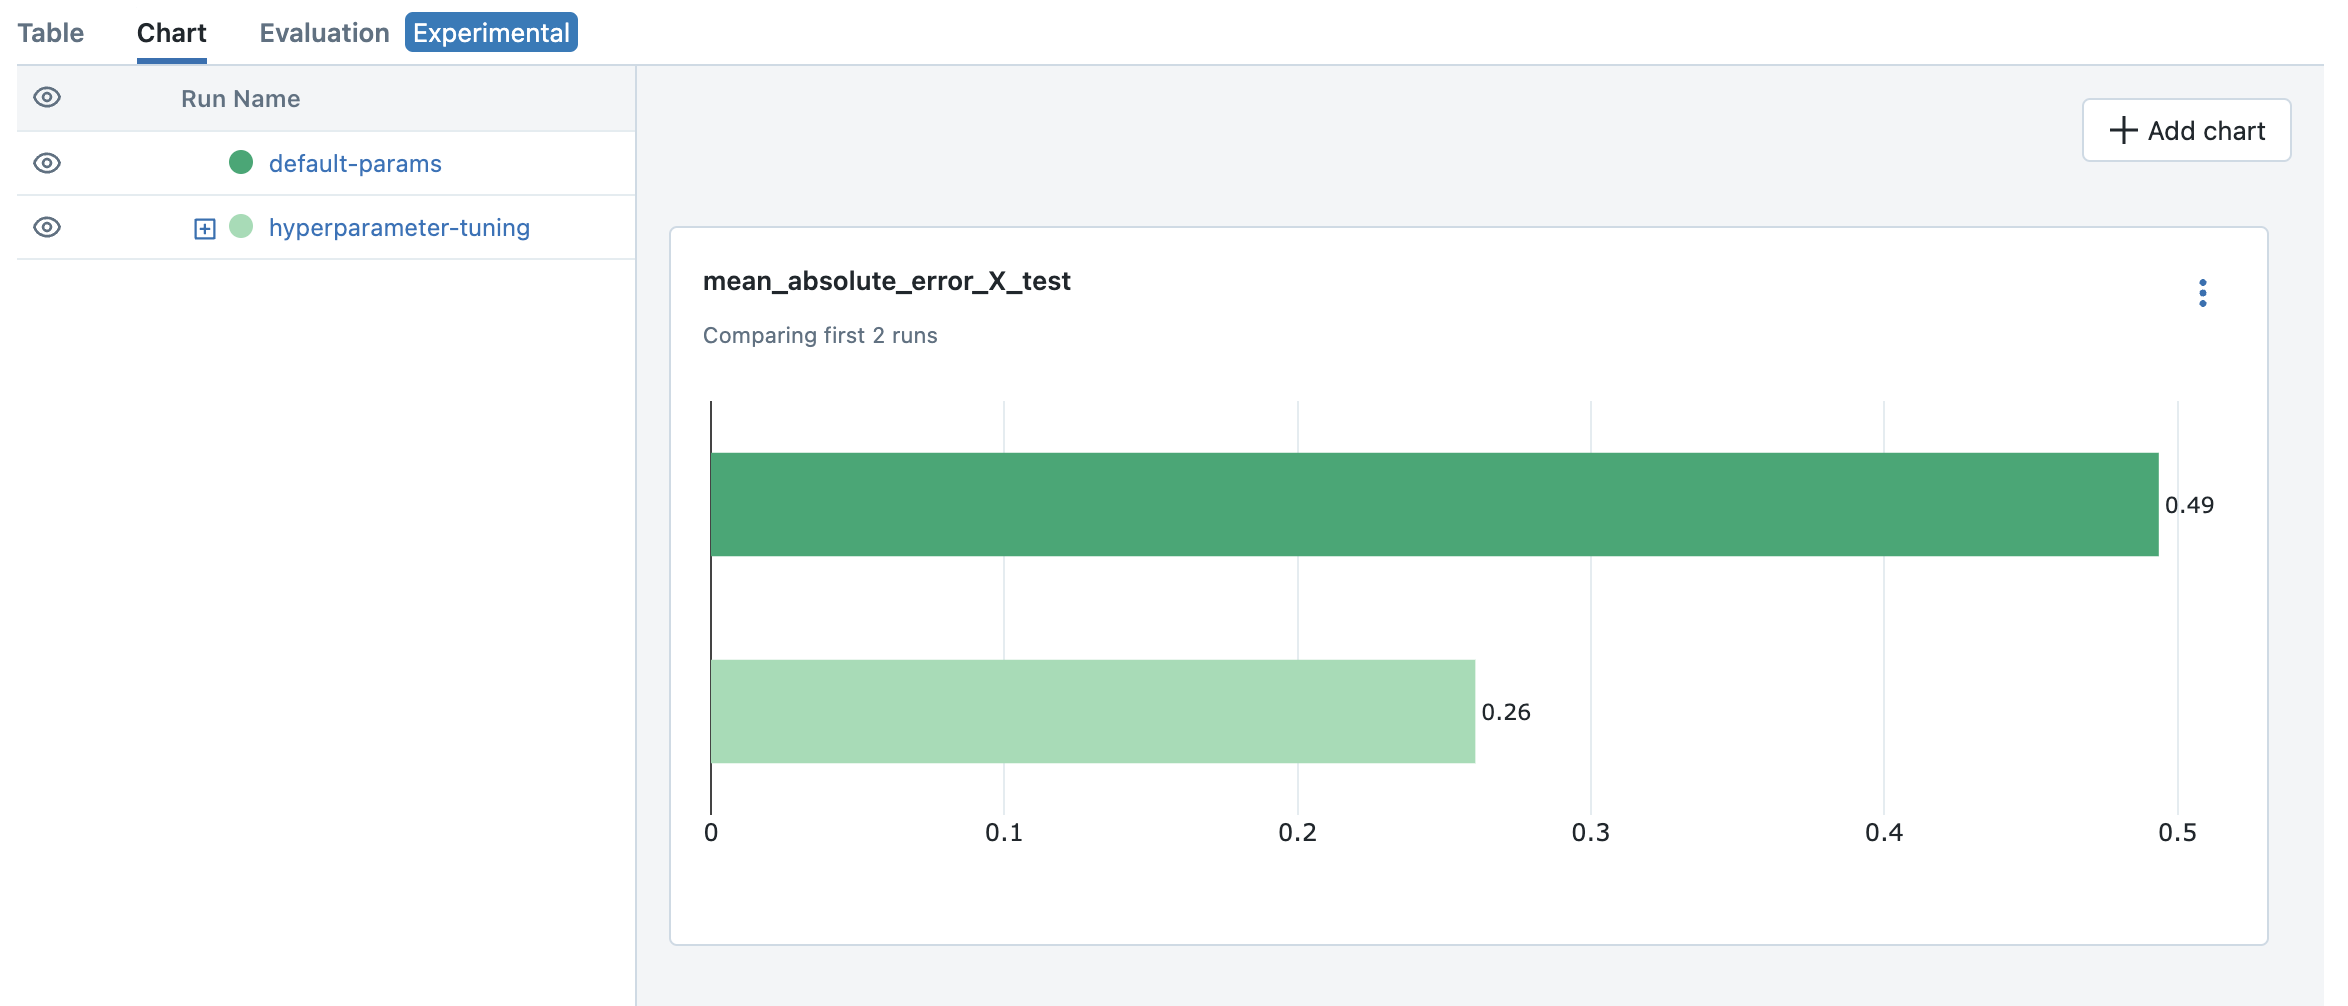


In [11]:
!mlflow models serve -m runs:/b7945e215f914e2f834720597b7e5379/model -p 1234 --enable-mlserver --no-conda

2025/08/26 17:41:33 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2025/08/26 17:45:40 WARNING mlflow.pyfunc.mlserver: Timeout is not yet supported in MLServer.
2025/08/26 17:45:40 INFO mlflow.pyfunc.backend: === Running command 'exec mlserver start /tmp/tmpareaf6c0/model/'
2025-08-26 17:45:42,252 [mlserver.parallel] DEBUG - Starting response processing loop...
2025-08-26 17:45:42,254 [mlserver.rest] INFO - HTTP server running on http://127.0.0.1:1234
INFO:     Started server process [24672]
INFO:     Waiting for application startup.
2025-08-26 17:45:42,291 [mlserver.metrics] INFO - Metrics server running on http://127.0.0.1:8082
2025-08-26 17:45:42,291 [mlserver.metrics] INFO - Prometheus scraping endpoint can be accessed on http://127.0.0.1:8082/metrics
INFO:     Started server process [24672]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
2025-08-26 17:45:43,032 [mlserver.grpc] INFO - gRPC server running 

In [ ]:
Alternative de serving (utilisable en production):
```
# Construire une image Docker contenant un modèle
# mlflow models build-docker -m runs:/b7945e215f914e2f834720597b7e5379/model -n "mon-modele-mlflow" --enable-mlserver

# Lancer le conteneur
# docker run -p 1234:8080 "mon-modele-mlflow"
```

Test du modèle en local avec une requête curl:
```
curl -X POST -H "Content-Type:application/json" -d "{\"inputs\": [[14.23, 1.71, 2.43, 15.6, 127.0, 2.8, 3.06, 0.28, 2.29, 5.64, 1.04, 3.92, 1065.0]]}" http://127.0.0.1:1234/invocations

{"predictions": [-0.03416275504140387]}
```

In [ ]:
# Sous Windows:
!curl -X POST -H "Content-Type:application/json" -d "{\"inputs\": [[14.23, 1.71, 2.43, 15.6, 127.0, 2.8, 3.06, 0.28, 2.29, 5.64, 1.04, 3.92, 1065.0]]}" http://127.0.0.1:1234/invocations

In [16]:
!curl -X POST -H "Content-Type: application/json" --data '{"dataframe_split": {"columns": ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol", "quality", "other_feature"], "data": [[14.23, 1.71, 2.43, 15.6, 127.0, 2.8, 3.06, 0.28, 2.29, 5.64, 1.04, 3.92, 1065.0]]}}' http://localhost:1234/invocations

{"predictions": [0.0639975235207515]}

## Ce qui suit vous montre comment récupérer les runs exécutés sur Google Colab pour les importer dans votre propre MLflow:

In [ ]:
# Comme le port 5000 (et probablement les autres ports) est fermé, récupérons le dossiers mlruns pour copier son contenu sur
# notre machine locale pour accéder au run dont on veut déployer et tester le modèle:
!zip -r experiment.zip mlruns

  adding: mlruns/ (stored 0%)
  adding: mlruns/434335839318448062/ (stored 0%)
  adding: mlruns/434335839318448062/943850241f8444f89dc59d1d392c2619/ (stored 0%)
  adding: mlruns/434335839318448062/943850241f8444f89dc59d1d392c2619/params/ (stored 0%)
  adding: mlruns/434335839318448062/943850241f8444f89dc59d1d392c2619/params/selection (stored 0%)
  adding: mlruns/434335839318448062/943850241f8444f89dc59d1d392c2619/params/l1_ratio (stored 0%)
  adding: mlruns/434335839318448062/943850241f8444f89dc59d1d392c2619/params/positive (stored 0%)
  adding: mlruns/434335839318448062/943850241f8444f89dc59d1d392c2619/params/warm_start (stored 0%)
  adding: mlruns/434335839318448062/943850241f8444f89dc59d1d392c2619/params/fit_intercept (stored 0%)
  adding: mlruns/434335839318448062/943850241f8444f89dc59d1d392c2619/params/alpha (stored 0%)
  adding: mlruns/434335839318448062/943850241f8444f89dc59d1d392c2619/params/copy_X (stored 0%)
  adding: mlruns/434335839318448062/943850241f8444f89dc59d1d392c2619

Construction d'une image Docker qui sera taguée mlflow-wine-classifier:latest :
```
mlflow models build-docker -m runs:/<run_id_for_your_best_run>/model -n <your_dockerhub_user_name>/mlflow-wine-classifier --enable-mlserver
```

Push de l'image Docker:
```
docker push <your_dockerhub_username>/mlflow-wine-classifier
```


# Déploiement du modèle sur KServe
Créons le namespace sur le cluster Kubernetes:
```
kubectl create namespace mlflow-kserve-test
```


Créer le fichier YAML ci-dessous qui décrit la configuration du déploiement:

```
apiVersion: "serving.kserve.io/v1beta1"
kind: "InferenceService"
metadata:
  name: "mlflow-wine-classifier"
  namespace: "mlflow-kserve-test"
spec:
  predictor:
    containers:
      - name: "mlflow-wine-classifier"
        image: "<your_docker_user_name>/mlflow-wine-classifier"
        ports:
          - containerPort: 8080
            protocol: TCP
        env:
          - name: PROTOCOL
            value: "v2"
```



Déployons un InferenceService sur le cluster K8s:
```
$ kubectl apply -f YOUR_CONFIG_FILE.yaml

inferenceservice.serving.kserve.io/mlflow-wine-classifier created

```
Vérifions l'état du déploiement:
```
$ kubectl get inferenceservice mlflow-wine-classifier

NAME                     URL                                                     READY   PREV   LATEST   PREVROLLEDOUTREVISION   LATESTREADYREVISION
mlflow-wine-classifier   http://mlflow-wine-classifier.mlflow-kserve-test.local   True             100                    mlflow-wine-classifier-100
```




Une fois le déploiement terminé, testons-le en créant un fichier JSON test-input.json comme suit:



```
{
    "inputs": [
      {
        "name": "input",
        "shape": [13],
        "datatype": "FP32",
        "data": [14.23, 1.71, 2.43, 15.6, 127.0, 2.8, 3.06, 0.28, 2.29, 5.64, 1.04, 3.92, 1065.0]
      }
    ]
}
```



Déterminer l'adresse IP et le port de l'ingress:
```
kubectl get svc istio-ingressgateway -n istio-system

NAME                   TYPE           CLUSTER-IP       EXTERNAL-IP      PORT(S)   AGE
istio-ingressgateway   LoadBalancer   172.21.109.129   130.211.10.121   ...       17h
```

Lançons ces commandes pour tester le service d'inférence:
```
$SERVICE_HOSTNAME=$(kubectl get inferenceservice mlflow-wine-classifier -n mlflow-kserve-test -o jsonpath='{.status.url}' | cut -d "/" -f 3)
$ curl -v \
  -H "Host: ${SERVICE_HOSTNAME}" \
  -H "Content-Type: application/json" \
  -d @./test-input.json \
  http://${INGRESS_HOST}:${INGRESS_PORT}/v2/models/mlflow-wine-classifier/infer
```



Documentation de KServe: https://kserve.github.io/website/0.10/get_started/first_isvc/#3-check-inferenceservice-status

In [ ]:
# requirements.txt
adal==1.2.7
adlfs==2024.12.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.12.15
aiohttp-retry==2.9.1
aiokafka==0.12.0
aiosignal==1.4.0
alembic==1.16.4
amqp==5.3.1
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.10.0
appdirs==1.4.4
argcomplete==3.6.2
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
arrow==1.3.0
asgiref==3.9.1
asttokens==3.0.0
async-lru==2.0.5
async-timeout==5.0.1
asyncssh==2.21.0
atpublic==6.0.1
attrs==25.3.0
azure-common==1.1.28
azure-core==1.35.0
azure-datalake-store==0.0.53
azure-graphrbac==0.61.2
azure-identity==1.24.0
azure-mgmt-authorization==4.0.0
azure-mgmt-containerregistry==13.0.0
azure-mgmt-core==1.6.0
azure-mgmt-keyvault==11.0.0
azure-mgmt-network==29.0.0
azure-mgmt-resource==24.0.0
azure-mgmt-storage==23.0.0
azure-storage-blob==12.26.0
azureml-core==1.60.0.post1
babel==2.17.0
backports.tempfile==1.0
backports.weakref==1.0.post1
bcrypt==4.3.0
beautifulsoup4==4.13.4
billiard==4.2.1
bleach==6.2.0
blinker==1.9.0
boto3==1.40.16
botocore==1.40.16
Brotli==1.1.0
cachetools==5.5.2
celery==5.5.3
certifi==2025.8.3
cffi==1.17.1
charset-normalizer==3.4.3
click==8.2.1
click-didyoumean==0.3.1
click-plugins==1.1.1.2
click-repl==0.3.0
cloudpickle==3.1.1
colorama==0.4.6
comm==0.2.3
configobj==5.0.9
contextlib2==21.6.0
contourpy==1.3.3
cryptography==45.0.6
cycler==0.12.1
databricks-sdk==0.64.0
debugpy==1.8.16
decorator==5.2.1
defusedxml==0.7.1
dictdiffer==0.9.0
diskcache==5.6.3
distlib==0.4.0
distro==1.9.0
docker==7.1.0
dpath==2.2.0
dulwich==0.24.1
durationpy==0.10
dvc==3.62.0
dvc-azure==3.1.0
dvc-data==3.16.12
dvc-http==2.32.0
dvc-objects==5.1.1
dvc-render==1.0.2
dvc-studio-client==0.22.0
dvc-task==0.40.2
entrypoints==0.4
executing==2.2.0
fastapi==0.115.14
fastjsonschema==2.21.2
filelock==3.19.1
Flask==3.1.2
flatten-dict==0.4.2
flufl.lock==8.2.0
fonttools==4.59.1
fqdn==1.5.1
frozenlist==1.7.0
fsspec==2025.7.0
funcy==2.0
gevent==25.5.1
geventhttpclient==2.3.4
gitdb==4.0.12
GitPython==3.1.45
google-api-core==2.25.1
google-auth==2.40.3
google-cloud-core==2.4.3
google-cloud-storage==3.3.0
google-crc32c==1.7.1
google-resumable-media==2.7.2
googleapis-common-protos==1.70.0
grandalf==0.8
graphene==3.4.3
graphql-core==3.2.6
graphql-relay==3.2.0
greenlet==3.2.4
grpcio==1.74.0
gto==1.8.0
gunicorn==23.0.0
h11==0.16.0
httpcore==1.0.9
httpx==0.28.1
humanfriendly==10.0
hydra-core==1.3.2
idna==3.10
importlib_metadata==8.7.0
importlib_resources==6.5.2
ipykernel==6.30.1
ipython==9.4.0
ipython_pygments_lexers==1.1.1
isodate==0.7.2
isoduration==20.11.0
iterative-telemetry==0.0.10
itsdangerous==2.2.0
jedi==0.19.2
jeepney==0.9.0
Jinja2==3.1.6
jmespath==1.0.1
joblib==1.5.1
json5==0.12.1
jsonpickle==4.1.1
jsonpointer==3.0.0
jsonschema==4.25.1
jsonschema-specifications==2025.4.1
jupyter-events==0.12.0
jupyter-lsp==2.2.6
jupyter_client==8.6.3
jupyter_core==5.8.1
jupyter_server==2.17.0
jupyter_server_terminals==0.5.3
jupyterlab==4.4.6
jupyterlab_pygments==0.3.0
jupyterlab_server==2.27.3
kiwisolver==1.4.9
knack==0.12.0
kombu==5.5.4
kubernetes==33.1.0
lark==1.2.2
Mako==1.3.10
markdown-it-py==4.0.0
MarkupSafe==3.0.2
matplotlib==3.10.5
matplotlib-inline==0.1.7
mdurl==0.1.2
mistune==3.1.3
mlflow==3.3.1
mlflow-skinny==3.3.1
mlflow-tracing==3.3.1
mlserver==1.7.1
mlserver-mlflow==1.7.1
msal==1.33.0
msal-extensions==1.3.1
msrest==0.7.1
msrestazure==0.6.4.post1
multidict==6.6.4
nbclient==0.10.2
nbconvert==7.16.6
nbformat==5.10.4
ndg-httpsclient==0.5.1
nest-asyncio==1.6.0
networkx==3.5
notebook==7.4.5
notebook_shim==0.2.4
numpy==2.3.2
oauthlib==3.3.1
omegaconf==2.3.0
opentelemetry-api==1.36.0
opentelemetry-exporter-otlp-proto-common==1.36.0
opentelemetry-exporter-otlp-proto-grpc==1.36.0
opentelemetry-instrumentation==0.57b0
opentelemetry-instrumentation-asgi==0.57b0
opentelemetry-instrumentation-fastapi==0.57b0
opentelemetry-instrumentation-grpc==0.57b0
opentelemetry-proto==1.36.0
opentelemetry-sdk==1.36.0
opentelemetry-semantic-conventions==0.57b0
opentelemetry-util-http==0.57b0
orjson==3.11.2
packaging==25.0
pandas==2.3.2
pandocfilters==1.5.1
paramiko==3.5.1
parso==0.8.5
pathspec==0.12.1
pexpect==4.9.0
pillow==11.3.0
pkginfo==1.12.1.2
platformdirs==4.3.8
prometheus_client==0.22.1
prometheus_flask_exporter==0.23.2
prompt_toolkit==3.0.51
propcache==0.3.2
proto-plus==1.26.1
protobuf==6.32.0
psutil==7.0.0
ptyprocess==0.7.0
pure_eval==0.2.3
py-grpc-prometheus==0.8.0
pyarrow==21.0.0
pyasn1==0.6.1
pyasn1_modules==0.4.2
pycparser==2.22
pydantic==2.11.7
pydantic-settings==2.10.1
pydantic_core==2.33.2
pydot==4.0.1
pygit2==1.18.2
Pygments==2.19.2
pygtrie==2.5.0
PyJWT==2.10.1
PyNaCl==1.5.0
pyOpenSSL==25.1.0
pyparsing==3.2.3
pysftp==0.2.9
PySocks==1.7.1
python-dateutil==2.9.0.post0
python-dotenv==1.1.1
python-json-logger==3.3.0
python-multipart==0.0.20
python-rapidjson==1.21
pytz==2025.2
PyYAML==6.0.2
pyzmq==27.0.2
referencing==0.36.2
requests==2.32.5
requests-auth-aws-sigv4==0.7
requests-oauthlib==2.0.0
rfc3339-validator==0.1.4
rfc3986-validator==0.1.1
rfc3987-syntax==1.1.0
rich==14.1.0
rpds-py==0.27.0
rsa==4.9.1
ruamel.yaml==0.18.15
ruamel.yaml.clib==0.2.12
s3transfer==0.13.1
scikit-learn==1.7.1
scipy==1.16.1
scmrepo==3.5.2
SecretStorage==3.3.3
semver==3.0.4
Send2Trash==1.8.3
setuptools==80.9.0
shellingham==1.5.4
shortuuid==1.0.13
shtab==1.7.2
six==1.17.0
smmap==5.0.2
sniffio==1.3.1
soupsieve==2.7
SQLAlchemy==2.0.43
sqlparse==0.5.3
sqltrie==0.11.2
stack-data==0.6.3
starlette==0.46.2
starlette_exporter==0.23.0
tabulate==0.9.0
terminado==0.18.1
threadpoolctl==3.6.0
tinycss2==1.4.0
tomlkit==0.13.3
tornado==6.5.2
tqdm==4.67.1
traitlets==5.14.3
tritonclient==2.59.0
typer==0.16.1
types-python-dateutil==2.9.0.20250822
typing-inspection==0.4.1
typing_extensions==4.14.1
tzdata==2025.2
uri-template==1.3.0
urllib3==2.5.0
uvicorn==0.35.0
uvloop==0.21.0
vine==5.1.0
virtualenv==20.34.0
voluptuous==0.15.2
wcwidth==0.2.13
webcolors==24.11.1
webencodings==0.5.1
websocket-client==1.8.0
Werkzeug==3.1.3
wrapt==1.17.3
yarl==1.20.1
zc.lockfile==3.0.post1
zipp==3.23.0
zope.event==5.1.1
zope.interface==7.2
